In [1]:
import matplotlib.pyplot as plt
import numpy as np

## Data Reader

In [2]:
def get_data(filename: str, x_axis, y_axis):
    arr_size = []
    arr_bw = []
    with open(filename, "r") as f:
        for row in f:
            tokens = row.split()
            arr_size.append(float(tokens[x_axis].split(")")[0]))
            arr_bw.append(float(tokens[y_axis]))
    

    return (arr_size, arr_bw)

## Caches

### GPU Caches ([RTX 2060](https://www.techpowerup.com/gpu-specs/geforce-rtx-2060.c3310))

In [3]:
max_bandwidth = 366 # GB/s
max_flops = 6451 # GFLOP/s

L1cache = 32768 * 30 # bytes
L2cache = 3145728 # bytes

N_L1cache= int(L1cache / 36) # 3 x 3 x 4bytes x N = L1cache
N_L2cache= int((L2cache + L1cache) / 36) # 3 x 3 x 4bytes x N = L2cache

print(f"L1 cache GPU: {L1cache} bytes, size: {N_L1cache}.")
print(f"L2 cache GPU: {L2cache} + {L1cache} bytes, size: {N_L2cache}.")

L1 cache GPU: 983040 bytes, size: 27306.
L2 cache GPU: 3145728 + 983040 bytes, size: 114688.


### CPU Caches ([AMD Opteron 6282 SE](https://www.cpu-world.com/CPUs/Bulldozer/AMD-Opteron%206282%20SE.html))

I set the environment variable `OMP_NUM_THREADS=8`. Therefore, only using half the caches, except L3 since it's shared.

In [4]:
L1cachecpu = 16000 * 8 # bytes
L2cachecpu = 1000000 * 8 # bytes
L3cachecpu = 16000000 # bytes

N_L1cachecpu= int(L1cachecpu / 36) # 3 x 3 x 4bytes x N = L1cache
N_L2cachecpu= int((L2cachecpu + L1cachecpu) / 36) # 3 x 3 x 4bytes x N = L2cache
N_L3cachecpu= int((L3cachecpu + L2cachecpu + L1cachecpu) / 36) # 3 x 3 x 4bytes x N = L3cache

print(f"L1 cache CPU: {L1cachecpu} bytes, size: {N_L1cachecpu}.")
print(f"L2 cache CPU: {L2cachecpu} + {L1cachecpu} bytes, size: {N_L2cachecpu}.")
print(f"L3 cache CPU: {L3cachecpu} + {L2cachecpu} + {L1cachecpu} bytes, size: {N_L3cachecpu}.")

L1 cache CPU: 128000 bytes, size: 3555.
L2 cache CPU: 8000000 + 128000 bytes, size: 225777.
L3 cache CPU: 16000000 + 8000000 + 128000 bytes, size: 670222.


## Task 2 and 4: CPU VS GPU and Memory Layout

### 1. Memory Bandwidth

In [5]:
idx_bandwidth = -15

FloatLeftCuda_x, FloatLeftCuda_y = get_data("FloatLeftCuda.txt", 4, idx_bandwidth)
FloatRightCuda_x, FloatRightCuda_y = get_data("FloatRightCuda.txt", 4, idx_bandwidth)
DoubleLeftCuda_x, DoubleLeftCuda_y = get_data("DoubleLeftCuda.txt", 4, idx_bandwidth)
DoubleRightCuda_x, DoubleRightCuda_y = get_data("DoubleRightCuda.txt", 4, idx_bandwidth)

FloatLeftCPU_x, FloatLeftCPU_y = get_data("FloatLeftCPU.txt", 4, idx_bandwidth)
FloatRightCPU_x, FloatRightCPU_y = get_data("FloatRightCPU.txt", 4, idx_bandwidth)
DoubleLeftCPU_x, DoubleLeftCPU_y = get_data("DoubleLeftCPU.txt", 4, idx_bandwidth)
DoubleRightCPU_x, DoubleRightCPU_y = get_data("DoubleRightCPU.txt", 4, idx_bandwidth)

#### 2.1. CPU

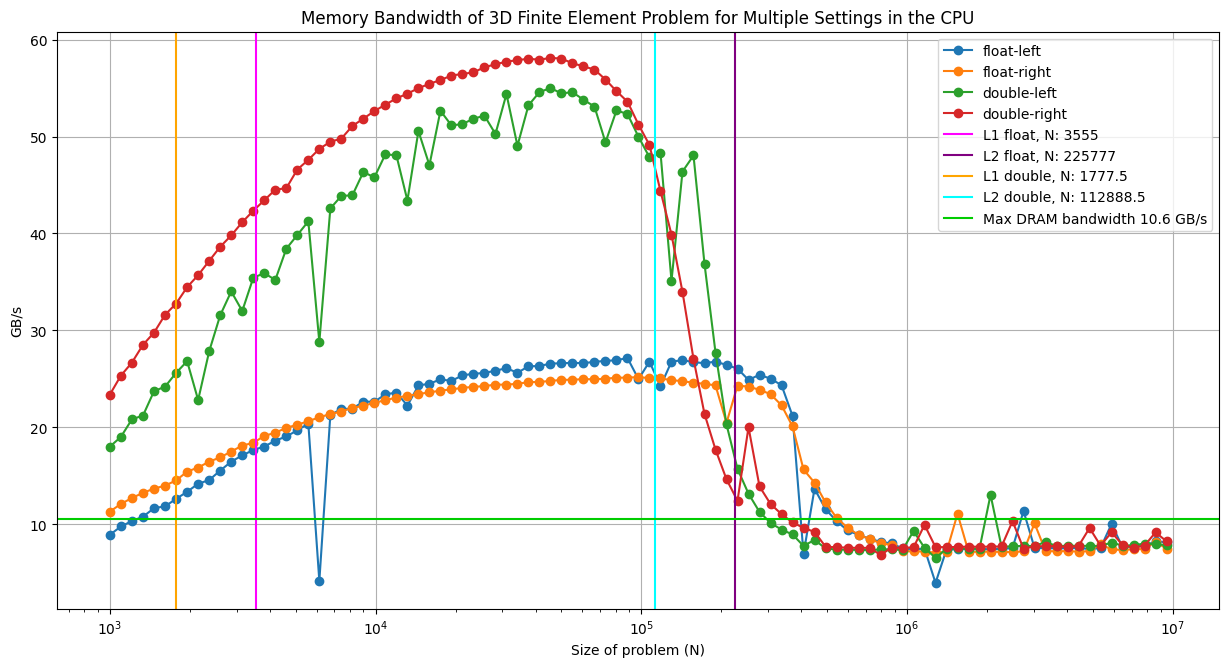

In [6]:
plt.figure(figsize=(15, 7.5))

plt.plot(FloatLeftCPU_x, FloatLeftCPU_y, "o-", label="float-left")
plt.plot(FloatRightCPU_x, FloatRightCPU_y, "o-", label="float-right")
plt.plot(DoubleLeftCPU_x, DoubleLeftCPU_y, "o-", label="double-left")
plt.plot(DoubleRightCPU_x, DoubleRightCPU_y, "o-", label="double-right")

plt.axvline(N_L1cachecpu, color="magenta", label=f"L1 float, N: {N_L1cachecpu}")
plt.axvline(N_L2cachecpu, color="purple", label=f"L2 float, N: {N_L2cachecpu}")
plt.axvline(N_L1cachecpu/2, color="orange", label=f"L1 double, N: {N_L1cachecpu/2}")
plt.axvline(N_L2cachecpu/2, color="cyan", label=f"L2 double, N: {N_L2cachecpu/2}")
plt.axhline(10.6, color='#00CC00', label=f"Max DRAM bandwidth 10.6 GB/s") # TODO: find out vitsippa.it.uu.se memory specification (without sudo how?)

# x, y = (2496, 73)
# plt.scatter([x], [y])
# plt.annotate(f"({x}, {y})", (x, y))

plt.xlabel("Size of problem (N)")
plt.ylabel("GB/s")
plt.legend()
plt.xscale("log")
# plt.yscale("log")
plt.grid("both")
plt.title("Memory Bandwidth of 3D Finite Element Problem for Multiple Settings in the CPU")
plt.show()

#### 2.2. GPU

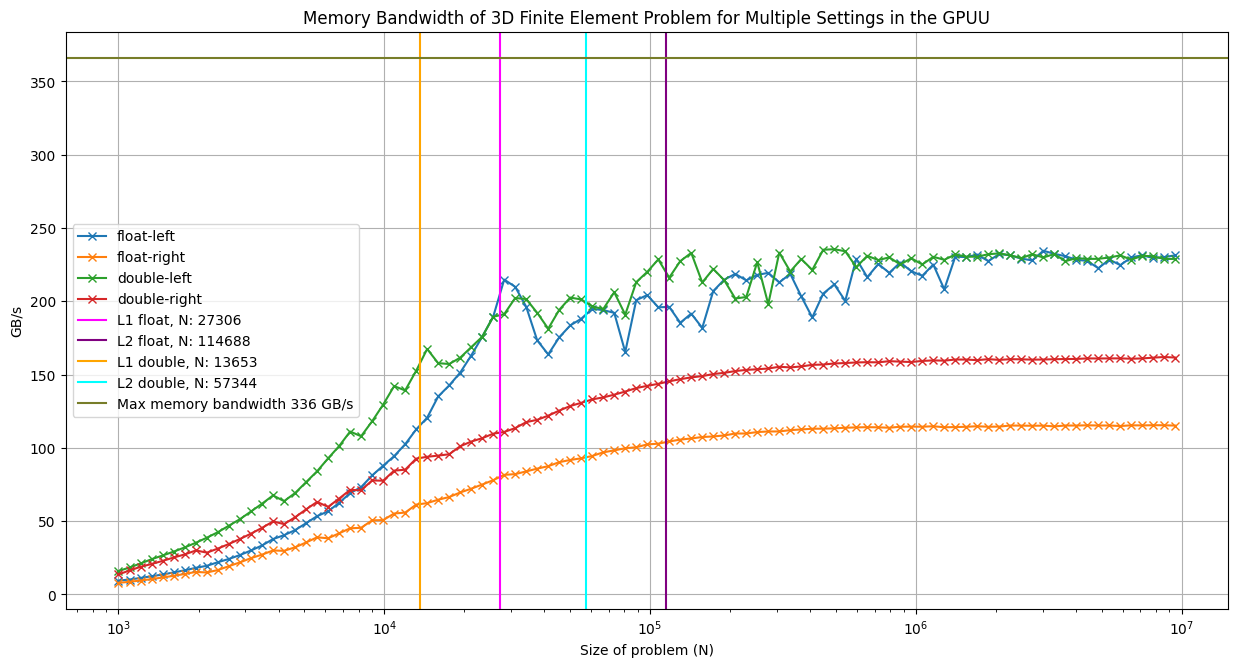

In [7]:
idx_bandwidth = -15

plt.figure(figsize=(15, 7.5))

plt.plot(FloatLeftCuda_x, FloatLeftCuda_y, "x-", label="float-left")
plt.plot(FloatRightCuda_x, FloatRightCuda_y, "x-", label="float-right")
plt.plot(DoubleLeftCuda_x, DoubleLeftCuda_y, "x-", label="double-left")
plt.plot(DoubleRightCuda_x, DoubleRightCuda_y, "x-", label="double-right")

plt.axvline(N_L1cache, color="magenta", label=f"L1 float, N: {int(N_L1cache)}")
plt.axvline(N_L2cache, color="purple", label=f"L2 float, N: {int(N_L2cache)}")
plt.axvline(N_L1cache/2, color="orange", label=f"L1 double, N: {int(N_L1cache/2)}")
plt.axvline(N_L2cache/2, color="cyan", label=f"L2 double, N: {int(N_L2cache/2)}")
plt.axhline(max_bandwidth, color='#777D29', label=f"Max memory bandwidth 336 GB/s")

# x = 2496
# y = 73
# plt.scatter([x], [y])
# plt.annotate(f"({x}, {y})", (x, y))

plt.xlabel("Size of problem (N)")
plt.ylabel("GB/s")
plt.legend()
plt.xscale("log")
# plt.yscale("log")
plt.grid("both")
plt.title("Memory Bandwidth of 3D Finite Element Problem for Multiple Settings in the GPUU")
plt.show()

### 2. Number of FL Operations per Second

In [8]:
idx_bandwidth = -11

FloatLeftCuda_x, FloatLeftCuda_y = get_data("FloatLeftCuda.txt", 4, idx_bandwidth)
FloatRightCuda_x, FloatRightCuda_y = get_data("FloatRightCuda.txt", 4, idx_bandwidth)
DoubleLeftCuda_x, DoubleLeftCuda_y = get_data("DoubleLeftCuda.txt", 4, idx_bandwidth)
DoubleRightCuda_x, DoubleRightCuda_y = get_data("DoubleRightCuda.txt", 4, idx_bandwidth)

FloatLeftCPU_x, FloatLeftCPU_y = get_data("FloatLeftCPU.txt", 4, idx_bandwidth)
FloatRightCPU_x, FloatRightCPU_y = get_data("FloatRightCPU.txt", 4, idx_bandwidth)
DoubleLeftCPU_x, DoubleLeftCPU_y = get_data("DoubleLeftCPU.txt", 4, idx_bandwidth)
DoubleRightCPU_x, DoubleRightCPU_y = get_data("DoubleRightCPU.txt", 4, idx_bandwidth)

#### 2.1. CPU

The theoretical FLOP/s of CPU is as follows:

$flops=clock\_speed\cdot num\_cores\cdot simd\_width\cdot inst\_per\_cycle\cdot flop\_per\_inst$

$=2.6\cdot 8\cdot 1\cdot 2\cdot 1=41.6$ gflop/s

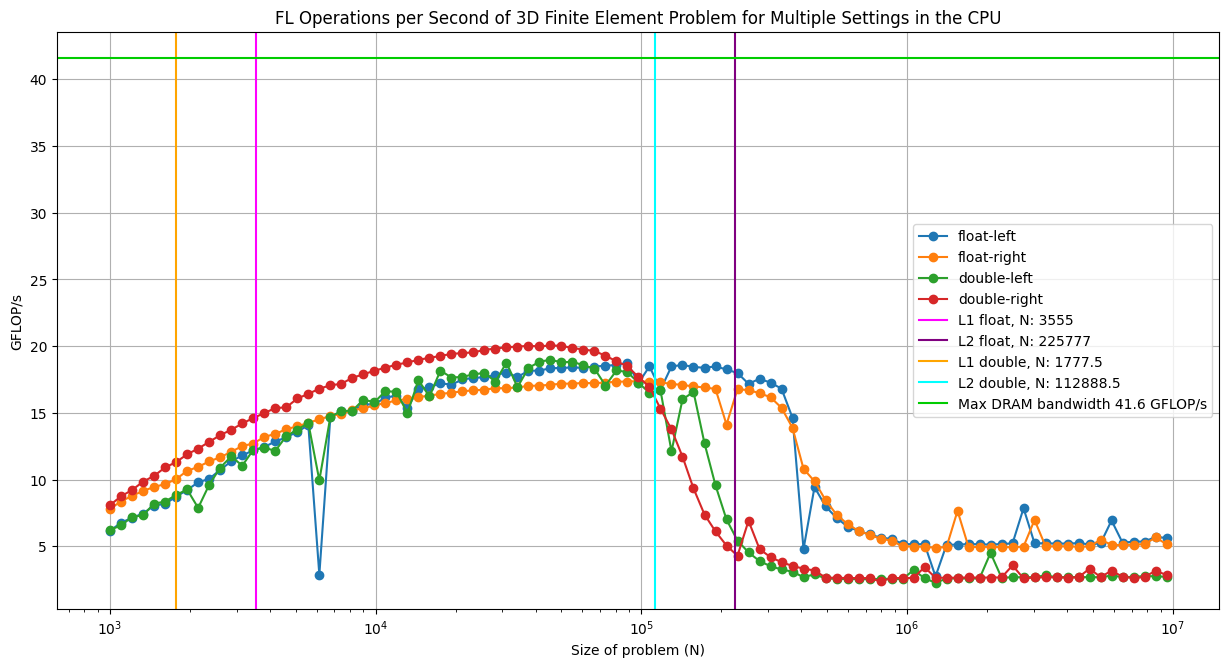

In [9]:
plt.figure(figsize=(15, 7.5))

plt.plot(FloatLeftCPU_x, FloatLeftCPU_y, "o-", label="float-left")
plt.plot(FloatRightCPU_x, FloatRightCPU_y, "o-", label="float-right")
plt.plot(DoubleLeftCPU_x, DoubleLeftCPU_y, "o-", label="double-left")
plt.plot(DoubleRightCPU_x, DoubleRightCPU_y, "o-", label="double-right")

plt.axvline(N_L1cachecpu, color="magenta", label=f"L1 float, N: {N_L1cachecpu}")
plt.axvline(N_L2cachecpu, color="purple", label=f"L2 float, N: {N_L2cachecpu}")
plt.axvline(N_L1cachecpu/2, color="orange", label=f"L1 double, N: {N_L1cachecpu/2}")
plt.axvline(N_L2cachecpu/2, color="cyan", label=f"L2 double, N: {N_L2cachecpu/2}")
plt.axhline(41.6, color='#00CC00', label=f"Max DRAM bandwidth 41.6 GFLOP/s") # Is the value correct? Seem reasonable

# x = 2496
# y = 73
# plt.scatter([x], [y])
# plt.annotate(f"({x}, {y})", (x, y))

plt.xlabel("Size of problem (N)")
plt.ylabel("GFLOP/s")
plt.legend()
plt.xscale("log")
# plt.yscale("log")
plt.grid("both")
plt.title("FL Operations per Second of 3D Finite Element Problem for Multiple Settings in the CPU")
plt.show()

#### 2.2. GPU

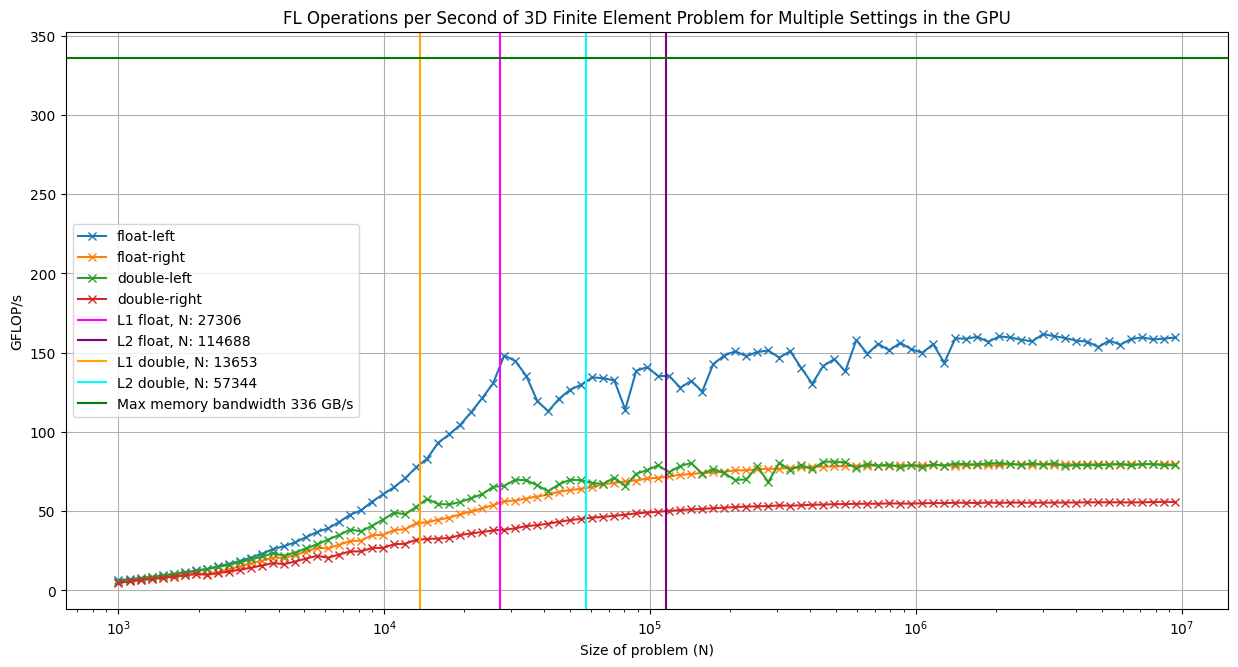

In [10]:
plt.figure(figsize=(15, 7.5))

plt.plot(FloatLeftCuda_x, FloatLeftCuda_y, "x-", label="float-left")
plt.plot(FloatRightCuda_x, FloatRightCuda_y, "x-", label="float-right")
plt.plot(DoubleLeftCuda_x, DoubleLeftCuda_y, "x-", label="double-left")
plt.plot(DoubleRightCuda_x, DoubleRightCuda_y, "x-", label="double-right")

plt.axvline(N_L1cache, color="magenta", label=f"L1 float, N: {int(N_L1cache)}")
plt.axvline(N_L2cache, color="purple", label=f"L2 float, N: {int(N_L2cache)}")
plt.axvline(N_L1cache/2, color="orange", label=f"L1 double, N: {int(N_L1cache/2)}")
plt.axvline(N_L2cache/2, color="cyan", label=f"L2 double, N: {int(N_L2cache/2)}")
plt.axhline(336, color='#007D00', label=f"Max memory bandwidth 336 GB/s")

# x = 2496
# y = 73
# plt.scatter([x], [y])
# plt.annotate(f"({x}, {y})", (x, y))

plt.xlabel("Size of problem (N)")
plt.ylabel("GFLOP/s")
plt.legend()
plt.xscale("log")
# plt.yscale("log")
plt.grid("both")
plt.title("FL Operations per Second of 3D Finite Element Problem for Multiple Settings in the GPU")
plt.show()

### 3. Number of Updates

In [11]:
idx_bandwidth = -13

FloatLeftCuda_x, FloatLeftCuda_y = get_data("FloatLeftCuda.txt", 4, idx_bandwidth)
FloatRightCuda_x, FloatRightCuda_y = get_data("FloatRightCuda.txt", 4, idx_bandwidth)
DoubleLeftCuda_x, DoubleLeftCuda_y = get_data("DoubleLeftCuda.txt", 4, idx_bandwidth)
DoubleRightCuda_x, DoubleRightCuda_y = get_data("DoubleRightCuda.txt", 4, idx_bandwidth)

FloatLeftCPU_x, FloatLeftCPU_y = get_data("FloatLeftCPU.txt", 4, idx_bandwidth)
FloatRightCPU_x, FloatRightCPU_y = get_data("FloatRightCPU.txt", 4, idx_bandwidth)
DoubleLeftCPU_x, DoubleLeftCPU_y = get_data("DoubleLeftCPU.txt", 4, idx_bandwidth)
DoubleRightCPU_x, DoubleRightCPU_y = get_data("DoubleRightCPU.txt", 4, idx_bandwidth)

#### 3.1. CPU

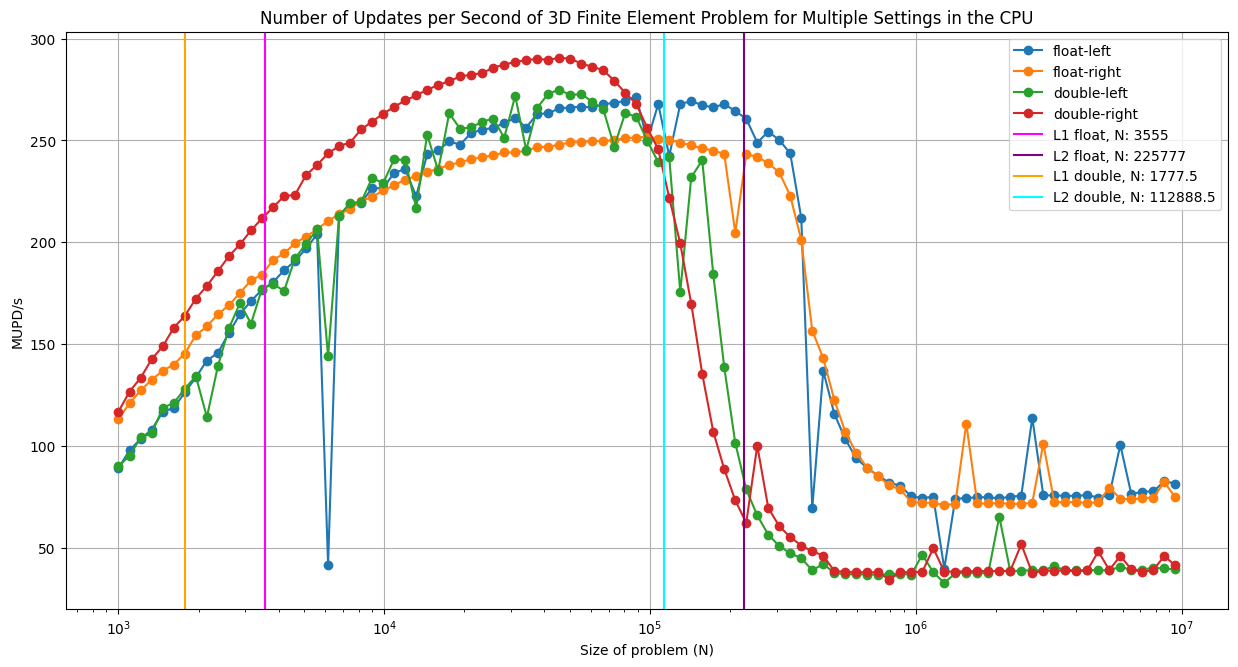

In [12]:
plt.figure(figsize=(15, 7.5))

plt.plot(FloatLeftCPU_x, FloatLeftCPU_y, "o-", label="float-left")
plt.plot(FloatRightCPU_x, FloatRightCPU_y, "o-", label="float-right")
plt.plot(DoubleLeftCPU_x, DoubleLeftCPU_y, "o-", label="double-left")
plt.plot(DoubleRightCPU_x, DoubleRightCPU_y, "o-", label="double-right")

plt.axvline(N_L1cachecpu, color="magenta", label=f"L1 float, N: {N_L1cachecpu}")
plt.axvline(N_L2cachecpu, color="purple", label=f"L2 float, N: {N_L2cachecpu}")
plt.axvline(N_L1cachecpu/2, color="orange", label=f"L1 double, N: {N_L1cachecpu/2}")
plt.axvline(N_L2cachecpu/2, color="cyan", label=f"L2 double, N: {N_L2cachecpu/2}")

# x = 2496
# y = 73
# plt.scatter([x], [y])
# plt.annotate(f"({x}, {y})", (x, y))

plt.xlabel("Size of problem (N)")
plt.ylabel("MUPD/s")
plt.legend()
plt.xscale("log")
# plt.yscale("log")
plt.grid("both")
plt.title("Number of Updates per Second of 3D Finite Element Problem for Multiple Settings in the CPU")
plt.show()

#### 3.2. GPU

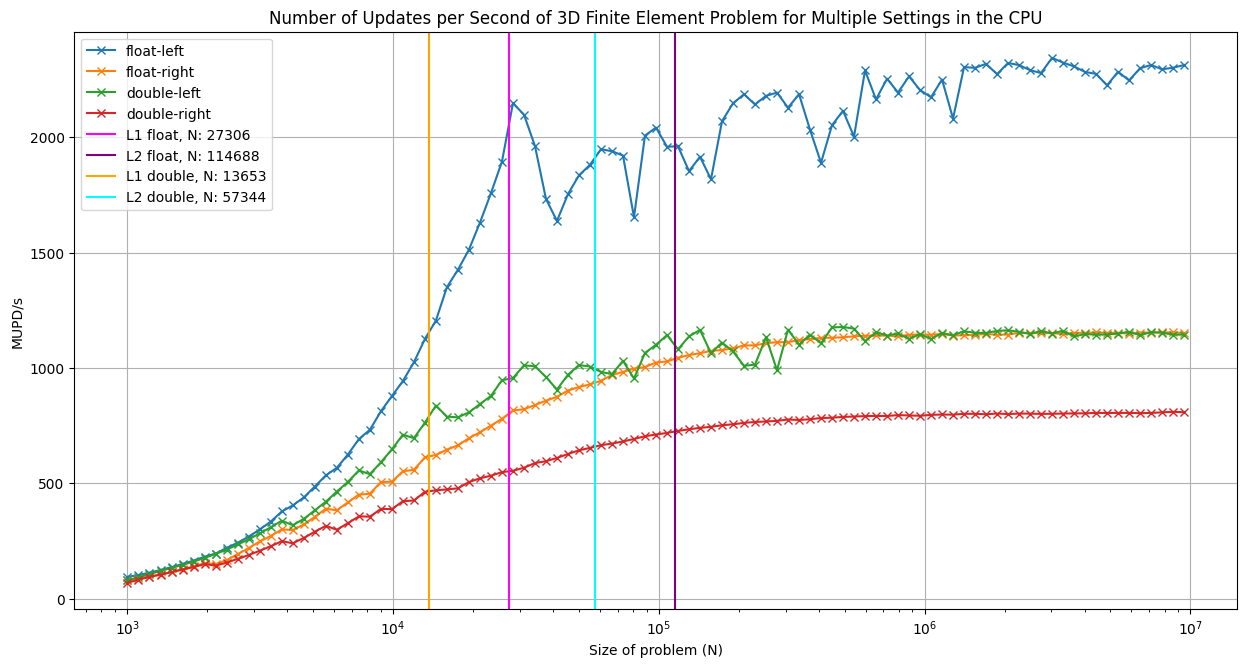

In [13]:
plt.figure(figsize=(15, 7.5))

plt.plot(FloatLeftCuda_x, FloatLeftCuda_y, "x-", label="float-left")
plt.plot(FloatRightCuda_x, FloatRightCuda_y, "x-", label="float-right")
plt.plot(DoubleLeftCuda_x, DoubleLeftCuda_y, "x-", label="double-left")
plt.plot(DoubleRightCuda_x, DoubleRightCuda_y, "x-", label="double-right")

plt.axvline(N_L1cache, color="magenta", label=f"L1 float, N: {int(N_L1cache)}")
plt.axvline(N_L2cache, color="purple", label=f"L2 float, N: {int(N_L2cache)}")
plt.axvline(N_L1cache/2, color="orange", label=f"L1 double, N: {int(N_L1cache/2)}")
plt.axvline(N_L2cache/2, color="cyan", label=f"L2 double, N: {int(N_L2cache/2)}")

# x = 2496
# y = 73
# plt.scatter([x], [y])
# plt.annotate(f"({x}, {y})", (x, y))

plt.xlabel("Size of problem (N)")
plt.ylabel("MUPD/s")
plt.legend()
plt.xscale("log")
# plt.yscale("log")
plt.grid("both")
plt.title("Number of Updates per Second of 3D Finite Element Problem for Multiple Settings in the CPU")
plt.show()